<a href="https://colab.research.google.com/github/arnav-meduri/PVO-segmentation/blob/main/pytorch_unet_resnet18_arnav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## pytorch-uent

https://github.com/usuyama/pytorch-unet

In [1]:
import os

if not os.path.exists("pytorch_unet.py"):
  if not os.path.exists("pytorch_unet"):
    !git clone https://github.com/usuyama/pytorch-unet.git

  %cd pytorch-unet

Cloning into 'pytorch-unet'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 67 (delta 6), reused 10 (delta 5), pack-reused 55
Receiving objects: 100% (67/67), 338.19 KiB | 9.39 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/pytorch-unet


In [2]:
!pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

  Cloning https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to /tmp/pip-req-build-x9_yxvem
  Running command git clone --filter=blob:none --quiet https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup /tmp/pip-req-build-x9_yxvem
  Resolved https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to commit 12d03c07553aedd3d9e9155e2b3e31ce8c64081a
  Preparing metadata (setup.py) ... done
  Created wheel for cosine-annealing-warmup: filename=cosine_annealing_warmup-2.0-py3-none-any.whl size=4168 sha256=f7889419c3f02aa3c911269a4b430b8a304ea633ba5ee47d05cf7daf1f6e18bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-hnyk9rc0/wheels/29/26/10/bf1a07417dd54aa73bdf09ce4f31c187974a444a1cedddbd99
Successfully built cosine-annealing-warmup


## Enabling GPU on Colab

Need to enable GPU from Notebook settings

- Navigate to Edit-Notebook settings menu
- Select GPU from the Hardware Accelerator dropdown list


In [3]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name Tesla T4


## Synthetic images for demo training

# Left: Input image (black and white), Right: Target mask (6ch)

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
!ls -aF "/content/drive/MyDrive/RCompSci/Normalized_Images/jul20/original"

'152 OD-1.png'	'24 OS-5.png'	'340 OD-3.png'	'45 OS-5.png'	'794 OD-4.png'
'152 OD-2.png'	'261 OD-1.png'	'340 OD-4.png'	'480 OD-1.png'	'794 OD-5.png'
'152 OD-3.png'	'261 OD-2.png'	'340 OD-5.png'	'480 OD-3.png'	'934 OD-1.png'
'152 OD-4.png'	'261 OD-3.png'	'352 OS-1.png'	'480 OD-4.png'	'934 OD-2.png'
'152 OD-5.png'	'261 OD-5.png'	'352 OS-4.png'	'480 OD-5.png'	'934 OD-3.png'
'1 OS-1.png'	'267 OS-1.png'	'357 OD-1.png'	'483 OS-2.png'	'934 OD-5.png'
'1 OS-4.png'	'267 OS-3.png'	'357 OD-3.png'	'483 OS-5.png'	'962 OD-4.png'
'223 OS-1.png'	'267 OS-4.png'	'357 OD-4.png'	'5 OS-2.png'	'966 OD-1.png'
'223 OS-2.png'	'275 OD-3.png'	'399 OD-1.png'	'690 OS-1.png'	'966 OD-2.png'
'223 OS-3.png'	'275 OD-5.png'	'399 OD-2.png'	'690 OS-3.png'	'966 OD-3.png'
'223 OS-4.png'	'2 OS-1.png'	'399 OD-3.png'	'694 OS-1.png'	'966 OD-4.png'
'223 OS-5.png'	'2 OS-2.png'	'399 OD-4.png'	'694 OS-2.png'	'966 OD-5.png'
'240 OD-4.png'	'2 OS-4.png'	'399 OD-5.png'	'694 OS-3.png'	'996 OS-3.png'
'240 OD-5.png'	'2 OS-5.png'	'45 OS-1.pn

In [9]:
! mkdir -p /content/Original_Images
! mkdir -p /content/Masked_Images
orig_folder = "/content/drive/MyDrive/RCompSci/Normalized_Images/jul20/original/"
!cp "$orig_folder"/*.png /content/Original_Images/
masked_folder = "/content/drive/MyDrive/RCompSci/Normalized_Images/jul20/annotated/"
!cp "$masked_folder"/*.png /content/Masked_Images/

In [10]:
!ls /content/Original_Images/ | wc -l
!ls /content/Masked_Images/ | wc -l

81
81


In [11]:
import torch
from torchvision import datasets, transforms
import glob
from PIL import Image
import numpy as np
import os
folder_image = glob.glob("/content/Original_Images/*.png")
folder_mask = glob.glob("/content/Masked_Images/*.png")
len_data = len(folder_image)
print(len_data)
len_mask = len(folder_mask)
print(len_mask)
image_list = []
mask_list = []
file_list = []
for path in folder_mask:
  #print(path)
  mask_list.append(path)
  file_list.append(path.replace("Masked_Images", "Original_Images"))
# for path in folder_image:
#   print(path)
#   file_list.append(path)

print(mask_list)
print(file_list)
for file in file_list:
  if os.path.isfile(file):
    image_list.append(file)
    image = Image.open(file)
    image = np.asarray(image)
  else:
    print(file)

print(len(image_list))
assert(file_list == image_list)


81
81
['/content/Masked_Images/2 OS-1.png', '/content/Masked_Images/966 OD-4.png', '/content/Masked_Images/794 OD-4.png', '/content/Masked_Images/152 OD-5.png', '/content/Masked_Images/480 OD-3.png', '/content/Masked_Images/399 OD-1.png', '/content/Masked_Images/45 OS-1.png', '/content/Masked_Images/352 OS-4.png', '/content/Masked_Images/996 OS-3.png', '/content/Masked_Images/2 OS-2.png', '/content/Masked_Images/24 OS-1.png', '/content/Masked_Images/24 OS-5.png', '/content/Masked_Images/2 OS-4.png', '/content/Masked_Images/45 OS-3.png', '/content/Masked_Images/483 OS-2.png', '/content/Masked_Images/319 OD-3.png', '/content/Masked_Images/352 OS-1.png', '/content/Masked_Images/694 OS-4.png', '/content/Masked_Images/223 OS-3.png', '/content/Masked_Images/45 OS-5.png', '/content/Masked_Images/2 OS-5.png', '/content/Masked_Images/240 OD-4.png', '/content/Masked_Images/152 OD-4.png', '/content/Masked_Images/1 OS-4.png', '/content/Masked_Images/223 OS-5.png', '/content/Masked_Images/966 OD-3.

In [12]:
train_size = 0.7
len_data = len(image_list)
train_image_paths = image_list[:int(len_data*train_size)]
test_image_paths = image_list[int(len_data*train_size):]

train_mask_paths = mask_list[:int(len_data*train_size)]
test_mask_paths = mask_list[int(len_data*train_size):]
print(train_image_paths)
print(train_mask_paths)

['/content/Original_Images/2 OS-1.png', '/content/Original_Images/966 OD-4.png', '/content/Original_Images/794 OD-4.png', '/content/Original_Images/152 OD-5.png', '/content/Original_Images/480 OD-3.png', '/content/Original_Images/399 OD-1.png', '/content/Original_Images/45 OS-1.png', '/content/Original_Images/352 OS-4.png', '/content/Original_Images/996 OS-3.png', '/content/Original_Images/2 OS-2.png', '/content/Original_Images/24 OS-1.png', '/content/Original_Images/24 OS-5.png', '/content/Original_Images/2 OS-4.png', '/content/Original_Images/45 OS-3.png', '/content/Original_Images/483 OS-2.png', '/content/Original_Images/319 OD-3.png', '/content/Original_Images/352 OS-1.png', '/content/Original_Images/694 OS-4.png', '/content/Original_Images/223 OS-3.png', '/content/Original_Images/45 OS-5.png', '/content/Original_Images/2 OS-5.png', '/content/Original_Images/240 OD-4.png', '/content/Original_Images/152 OD-4.png', '/content/Original_Images/1 OS-4.png', '/content/Original_Images/223 

In [13]:
from torch.utils.data.dataset import Dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):   # initial logic


         self.image_paths = image_paths
         self.target_paths = target_paths
         self.transforms = transforms.ToTensor()

    def __getitem__(self, index):

        image = Image.open(self.image_paths[index])

        mask = Image.open(self.target_paths[index])
        # print(np.max(np.asarray(image)))
        # print(np.max(np.asarray(mask)))
        t_image = self.transforms(image)
        t_mask = self.transforms(mask)
        t_mask[t_mask>0] = 1

        t_image = t_image.repeat(3, 1, 1)
        return t_image, t_mask

    def __len__(self):  # return count of sample we have

        return len(self.image_paths)


batch_size = 4


train_dataset = CustomDataset(train_image_paths, train_mask_paths, train=True)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1)

test_dataset = CustomDataset(test_image_paths, test_mask_paths, train=False)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)
dataloaders = {
  'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1),
  'val': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
}

## Prepare Dataset and DataLoader

## Check the outputs from DataLoader

243
(512, 512, 3) torch.Size([4, 3, 512, 512])
tensor([1.0484e+06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

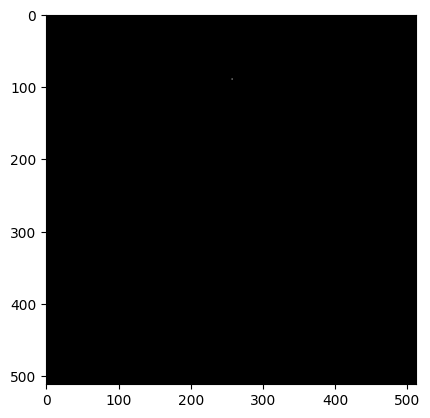

In [14]:
import torchvision.utils
from matplotlib import pyplot as plt
def reverse_transform(inp):
  inp = inp.numpy().transpose((1, 2, 0))
  # mean = np.array([0.485, 0.456, 0.406])
  # std = np.array([0.229, 0.224, 0.225])
  # inp = std * inp + mean
  # inp = np.clip(inp, 0, 1)
  inp = (inp * 255).astype(np.uint8)
  print(np.max(inp))
  return np.squeeze(inp)

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(reverse_transform(inputs[3]).shape, inputs.shape)

plt.imshow(np.squeeze(masks[1]),cmap='gray', vmin=0, vmax=1)
print(torch.histc(masks))

# Define a UNet module

In [15]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

## Instantiate the UNet model

- Move the model to GPU if available
- Show model summaries

In [16]:
import torch
import torch.nn as nn
import pytorch_unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

model = ResNetUNet(1)
model = model.to(device)
torch.set_num_threads(20)

device cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 82.6MB/s]


In [17]:
model

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [18]:
from torchsummary import summary
summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
            Conv2d-5         [-1, 64, 256, 256]           9,408
            Conv2d-6         [-1, 64, 256, 256]           9,408
       BatchNorm2d-7         [-1, 64, 256, 256]             128
       BatchNorm2d-8         [-1, 64, 256, 256]             128
              ReLU-9         [-1, 64, 256, 256]               0
             ReLU-10         [-1, 64, 256, 256]               0
        MaxPool2d-11         [-1, 64, 128, 128]               0
        MaxPool2d-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 64, 128, 128]          36,864
           Conv2d-14         [-1, 64, 1

# Define the main training loop

In [19]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

checkpoint_path = "checkpoint_bce0.5.pth"

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10
    best_epoch = -1
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics, bce_weight=0.5)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
#                         print("LR",optimizer.param_groups[-1]['lr'])
                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':

              for param_group in optimizer.param_groups:
                  print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                best_epoch = epoch
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

## Training

In [20]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

num_class = 1
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
for l in model.base_layers:
  for param in l.parameters():
    param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)
# optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, momentum=0.9,weight_decay = 0.0005)
scheduler = CosineAnnealingWarmupRestarts(optimizer_ft,
                                          first_cycle_steps=200,
                                          cycle_mult=1.0,
                                          max_lr=0.001,
                                          min_lr=0.00001,
                                          warmup_steps=10,
                                          gamma=1.0)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

model = train_model(model, optimizer_ft, scheduler, num_epochs=300)

Epoch 0/299
----------
train: bce: 0.273927, dice: 0.922180, loss: 0.598054
LR 0.0009989177454732933
val: bce: 0.125737, dice: 0.849926, loss: 0.487832
saving best model to checkpoint_bce0.5.pth
0m 8s
Epoch 1/299
----------
train: bce: 0.040635, dice: 0.879469, loss: 0.460052
LR 0.000978237711859507
val: bce: 0.019242, dice: 0.849926, loss: 0.434584
saving best model to checkpoint_bce0.5.pth
0m 7s
Epoch 2/299
----------
train: bce: 0.016891, dice: 0.860060, loss: 0.438475
LR 0.000932311958073999
val: bce: 0.012550, dice: 0.849926, loss: 0.431238
saving best model to checkpoint_bce0.5.pth
0m 7s
Epoch 3/299
----------
train: bce: 0.003829, dice: 0.860223, loss: 0.432026
LR 0.0008635904763715891
val: bce: 0.002510, dice: 0.850299, loss: 0.426404
saving best model to checkpoint_bce0.5.pth
0m 7s
Epoch 4/299
----------
train: bce: 0.002025, dice: 0.860461, loss: 0.431243
LR 0.0007757393382706014
val: bce: 0.002383, dice: 0.849973, loss: 0.426178
saving best model to checkpoint_bce0.5.pth
0m 

## Predict new images using the trained model

inputs.shape torch.Size([3, 512, 512])
labels.shape torch.Size([4, 1, 512, 512])
pred.shape (4, 1, 512, 512)
pred.max 0.049475513


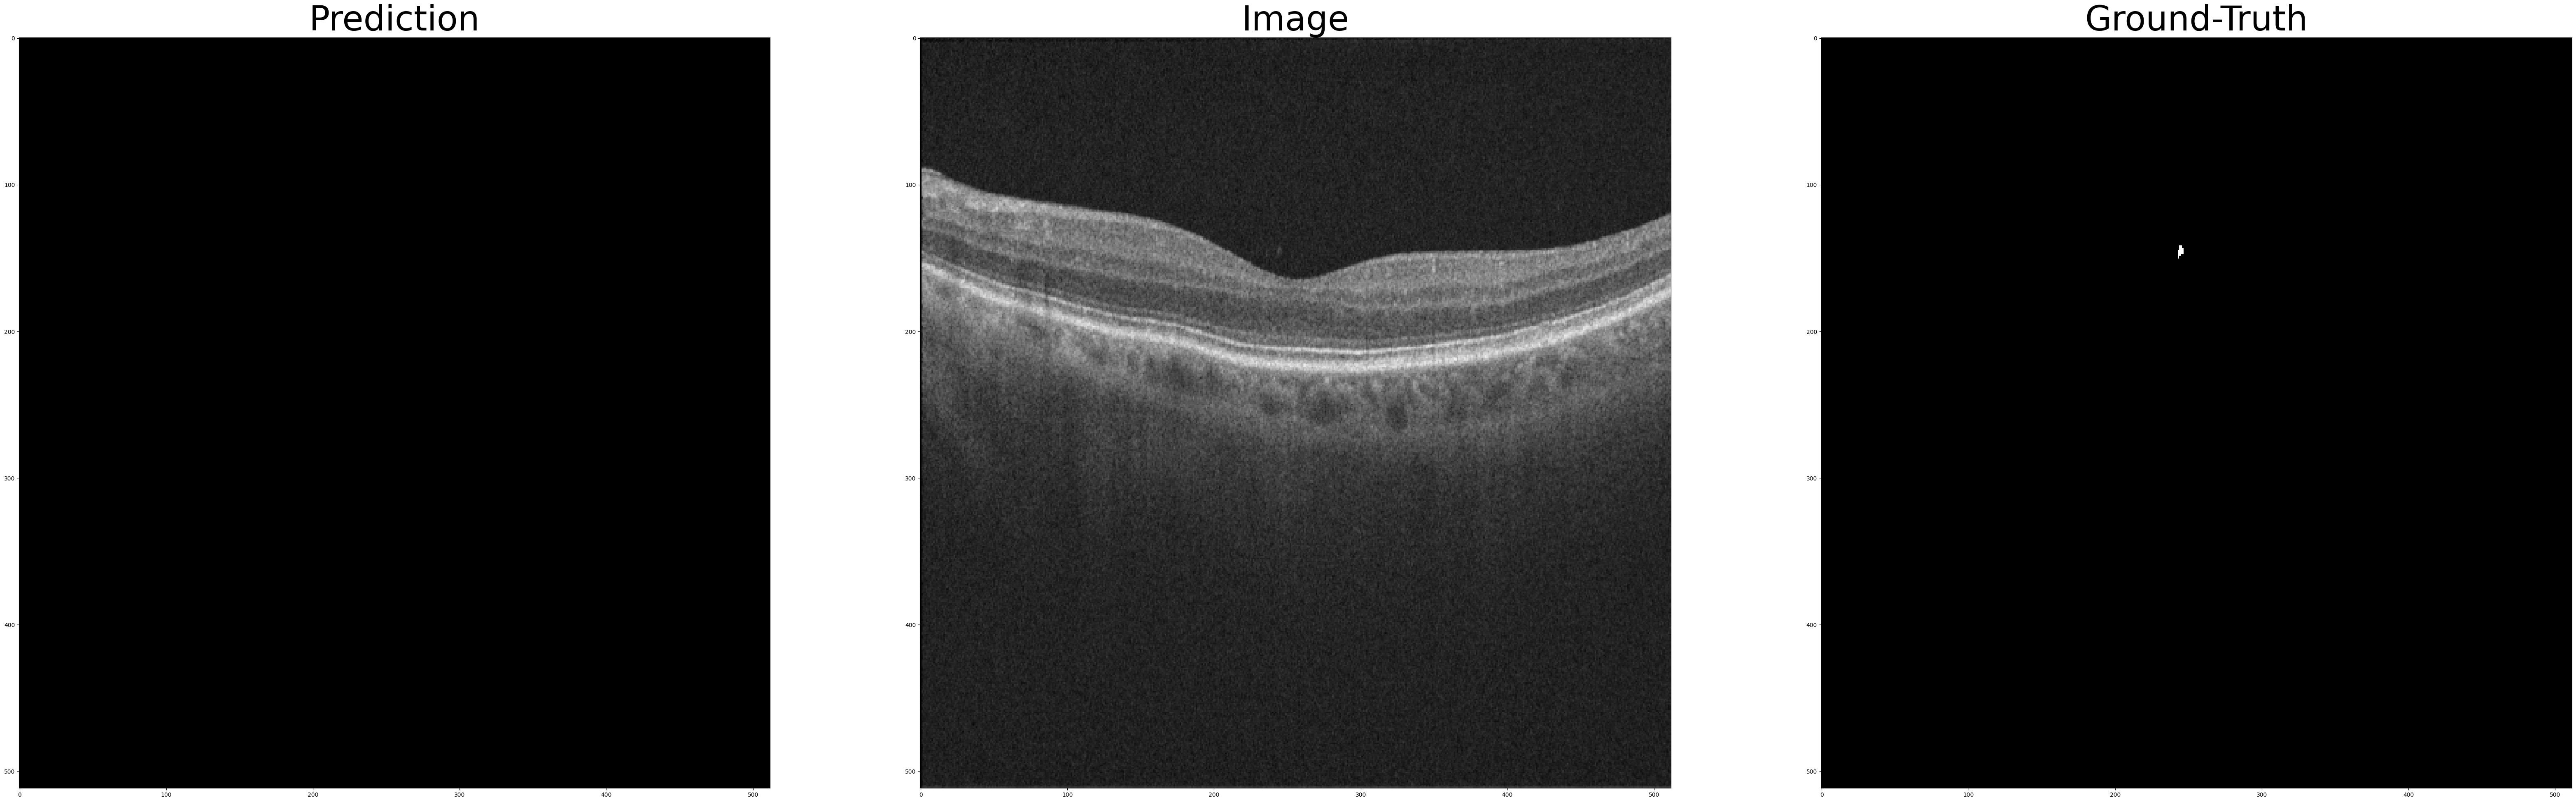

In [21]:
import math

model.eval()   # Set model to the evaluation mode
fig = plt.figure(figsize=(80, 40))
# Create a new simulation dataset for testing
# test_dataset = SimDataset(3, transform = trans)
# test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

# Get the first batch
inputs, masks =  next(iter(dataloaders['val']))
inputs = inputs.to(device)
labels = masks.to(device)
print('inputs.shape', inputs[1].shape)
print('labels.shape', labels.shape)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
inputs = inputs.data.cpu().numpy()
print('pred.shape', pred.shape)
print('pred.max', np.max(pred))
rows =1
columns =3
val_index = 2
fig.add_subplot(rows, columns, 1)
plt.title('Prediction',fontsize=60)
plt.imshow(np.squeeze(pred[val_index]),cmap='gray', vmin=0, vmax=1)
fig.add_subplot(rows, columns, 2)
plt.title('Image',fontsize=60)
plt.imshow(np.squeeze(inputs[val_index][0,:,:]),cmap='gray', vmin=0, vmax=1)
fig.add_subplot(rows, columns, 3)
plt.title('Ground-Truth',fontsize=60)
plt.imshow(np.squeeze(masks[val_index]),cmap='gray', vmin=0, vmax=1)

In [23]:
torch.save(model.state_dict(), "/content/model_state_dict.pth")

In [24]:
!cp "/content/model_state_dict.pth" "/content/drive/MyDrive/RCompSci/Normalized_Images/jul20/"